In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import sklearn
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'gender_submission.csv']


## Plotting libraries

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] =12,8

## Reading the input

In [3]:
path =  "../input/"

df_train = pd.read_csv(f'{path}train.csv', index_col = 'PassengerId')
df_test = pd.read_csv(f'{path}test.csv', index_col = 'PassengerId')

target = df_train['Survived']
target.columns = ['Survived']
df_train = df_train.drop(labels = 'Survived', axis = 1)

## Data handling

For the purpose of data manipulation, we concatenate the test and training sets, so that all changes are made equivalently on each of them. To differentiate between test and training, we mark them with a new temporary `Training_set` column `True` for the training set and `False` for the test set.

In [4]:
df_train['Training_set']= True
df_test['Training_set'] = False

df_full = pd.concat([df_train,df_test])

Let's look at a summary of the data info.

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Pclass          1309 non-null int64
Name            1309 non-null object
Sex             1309 non-null object
Age             1046 non-null float64
SibSp           1309 non-null int64
Parch           1309 non-null int64
Ticket          1309 non-null object
Fare            1308 non-null float64
Cabin           295 non-null object
Embarked        1307 non-null object
Training_set    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(5)
memory usage: 113.8+ KB


To figure out the number of null values in each data set.

In [6]:
df_full.isnull().sum()[df_full.isnull().sum()>0]

Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

We drop the columns that are irrelevant /  have no effect on our model.

In [7]:
df_full = df_full.drop(labels = ['Ticket','Name', 'Cabin'], axis = 1)
df_full

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Training_set
PassengerId,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,True
2,1,female,38.0,1,0,71.2833,C,True
3,3,female,26.0,0,0,7.9250,S,True
4,1,female,35.0,1,0,53.1000,S,True
5,3,male,35.0,0,0,8.0500,S,True
6,3,male,NaN,0,0,8.4583,Q,True
7,1,male,54.0,0,0,51.8625,S,True
8,3,male,2.0,3,1,21.0750,S,True
9,3,female,27.0,0,2,11.1333,S,True


Let's fill in the null values and remove categorical data using `.fillna()` and `.get_dummies()` respectively.

In [8]:
df_full.Age = df_full.Age.fillna(df_full.Age.mean())
df_full.Fare = df_full.Fare.fillna(df_full.Fare.mean())
df_full.Embarked = df_full.fillna(df_full.Embarked.mode()[0])

df_full = df_full.interpolate()
df_full = pd.get_dummies(df_full)
df_full

,Pclass,Age,SibSp,Parch,Fare,Training_set,Sex_female,Sex_male,Embarked_1,Embarked_2,Embarked_3
PassengerId,,,,,,,,,,,
1,3,22.000000,1,0,7.2500,True,0,1,0,0,1
2,1,38.000000,1,0,71.2833,True,1,0,1,0,0
3,3,26.000000,0,0,7.9250,True,1,0,0,0,1
4,1,35.000000,1,0,53.1000,True,1,0,1,0,0
5,3,35.000000,0,0,8.0500,True,0,1,0,0,1
6,3,29.881138,0,0,8.4583,True,0,1,0,0,1
7,1,54.000000,0,0,51.8625,True,0,1,1,0,0
8,3,2.000000,3,1,21.0750,True,0,1,0,0,1
9,3,27.000000,0,2,11.1333,True,1,0,0,0,1


Since we have a dataframe with workable values, we redistribute the data set into training and test sets. And drop the differentiating temporary column `Training_set`.

In [9]:
df_train = df_full[df_full['Training_set']==True]
df_test = df_full[df_full['Training_set']==False]

In [10]:
df_train.drop(labels = 'Training_set', inplace = True, axis = 1)
df_test.drop(labels ='Training_set', inplace = True, axis = 1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Method 1: Neural Network with Pytorch

Convert the dataframes into torch tensors to be used for our model. We also perform dev/train/test splits for cross-validation of our model. 

In [11]:
torch.manual_seed(2) #setting a seed so that the results are reproducible
msk = np.random.randn(len(df_train)) < 0.8

training_features = torch.tensor(df_train[msk].values.astype('float32'))
dev_features = torch.tensor(df_train[~msk].values.astype('float32'))

training_labels = torch.tensor(target[msk].values)
dev_labels = torch.tensor(target[~msk].values)

test_features = torch.tensor(df_test.values.astype('float32'))

## Model Definition

We define our model as a `3 layer network`. <br>
LINEAR -> RELU -> DROPOUT -> LINEAR -> RELU -> DROPOUT ->LINEAR -> LOGSOFTMAX <br>
With `ReLU` activations and a dropout probaility of 0.2, and the output using `LogSoftmax` activation.  <br>
We use negative log likelihood loss as our criterion. We use `Adam` optimizer with learning rate `0.003`.

In [12]:
model = nn.Sequential(nn.Linear(10,5),nn.ReLU(),nn.Dropout(p=0.2),nn.Linear(5,5),nn.ReLU(), nn.Dropout(p=0.1),nn.Linear(5,2),nn.LogSoftmax(dim =1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

Helper functions `evaluate`. Returns Test loss during validation/testing else the output using `one hot encoding` 

In [13]:
def evaluate(model,test_features,test_labels=None,print_acc_and_cost = False, testing = False):
    with torch.no_grad():
        test_loss =0
        log_preds = model(test_features)
        preds=torch.exp(log_preds)
        preds, survived = torch.max(preds, 1)
        if(testing):
            loss = criterion(log_preds,test_labels)
            equals = survived==test_labels.view(*survived.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            test_loss += loss.item()
            if(print_acc_and_cost):
                print(f'Testing accuracy : {accuracy*100:.3f}%')
                print(f'Testing Loss : {test_loss:.3f}')
            return test_loss
        else:
            return survived
        #print(survived)

## Training the model

Epoch : 100/1000...
Testing accuracy : 62.712%
Testing Loss : 0.659
Training loss 0.604

Epoch : 200/1000...
Testing accuracy : 79.661%
Testing Loss : 0.508
Training loss 0.494

Epoch : 300/1000...
Testing accuracy : 80.226%
Testing Loss : 0.457
Training loss 0.449

Epoch : 400/1000...
Testing accuracy : 78.531%
Testing Loss : 0.457
Training loss 0.456

Epoch : 500/1000...
Testing accuracy : 77.401%
Testing Loss : 0.457
Training loss 0.470

Epoch : 600/1000...
Testing accuracy : 77.401%
Testing Loss : 0.461
Training loss 0.465

Epoch : 700/1000...
Testing accuracy : 77.401%
Testing Loss : 0.462
Training loss 0.450

Epoch : 800/1000...
Testing accuracy : 78.531%
Testing Loss : 0.460
Training loss 0.440

Epoch : 900/1000...
Testing accuracy : 78.531%
Testing Loss : 0.457
Training loss 0.465

Epoch : 1000/1000...
Testing accuracy : 77.966%
Testing Loss : 0.457
Training loss 0.442



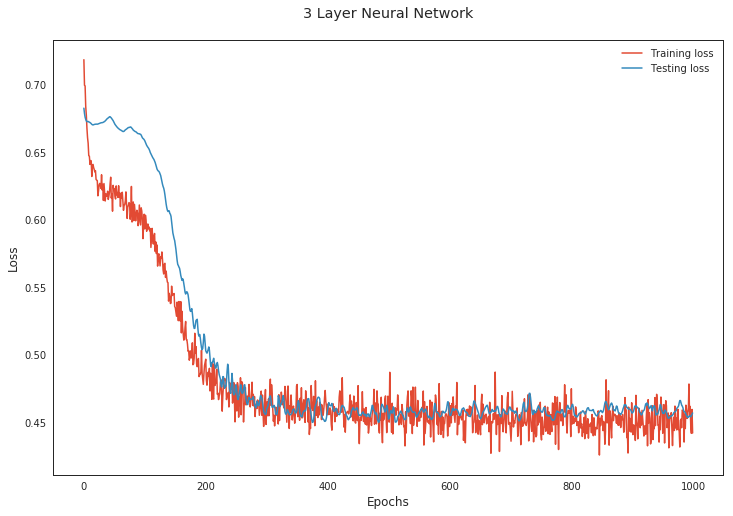

In [14]:
epochs = 1000
steps = 0
training_losses,testing_losses = [],[]
for e in range(epochs):
    running_loss = 0
    optimizer.zero_grad()
    
    log_outputs = model(training_features)
    loss = criterion(log_outputs,training_labels)
    
    loss.backward()
    outputs = torch.exp(log_outputs)
    
    optimizer.step()
    steps += 1
    running_loss += loss.item()
    training_losses.append(running_loss)
    if(steps%100==0):
        with torch.no_grad():
            model.eval()
            print(f'Epoch : {e+1}/{epochs}...')
            testing_losses.append(evaluate(model,dev_features, test_labels = dev_labels, print_acc_and_cost=True, testing = True))
        print(f'Training loss {running_loss:.3f}\n')
    else:
        with torch.no_grad():
            model.eval()
            testing_losses.append(evaluate(model,dev_features, test_labels = dev_labels, print_acc_and_cost=False, testing = True))
    model.train()

plt.plot(training_losses,label='Training loss')
plt.plot(testing_losses, label='Testing loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("3 Layer Neural Network\n")
plt.legend(frameon = False)

## Predictions

In [15]:
survived = evaluate(model,test_features)
my_submission = pd.DataFrame({'PassengerId':df_test.index,'Survived':survived})
my_submission.to_csv('./submission.csv', index = False)
!ls

__notebook__.ipynb  __output__.json  submission.csv


## Method 2: Using Sklearn

Train test(validation) splitting.

In [16]:
np.random.seed(0)
from sklearn import model_selection
X_train, X_val, y_train, y_val = model_selection.train_test_split(df_train,target, test_size = 0.2, train_size = 0.8, random_state = 0 )
#print(X_train.shape,y_train.shape,X_val.shape, y_val.shape)

Importing various model packages.

In [17]:
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import gaussian_process
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import svm
from sklearn import discriminant_analysis
from xgboost.sklearn import XGBClassifier

## Model Comparison

We compare various algorithms. `GradientBoostingClassifier` turns out to have least test accuracy.

List out all the algorithms to be compared. 

In [18]:
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.RandomForestClassifier(n_estimators = 100, random_state = 0),
    
    gaussian_process.GaussianProcessClassifier(),
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.NuSVC(probability = True),
    svm.LinearSVC(),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    XGBClassifier(), 
    
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron()
]

We create a dataframe to compare our algorithms. The columns are as follows.

In [19]:
MLA_columns = ['MLA_names', 'MLA_parameters', 'MLA_Train_Accuracy_Mean'
               ,'MLA_Test_Accuracy_Mean', 'MLA_Test_Accuracy_3*STD', 
               'MLA_Time']

MLA_compare = pd.DataFrame(columns = MLA_columns)

Because we haven't set a lot of parameters in our algorithms list, we'll have a lot of warnings popup.<br>
(hiding warnings just for the aesthetics)

In [20]:
import warnings
warnings.filterwarnings('ignore')

We iterate through the algorithms list and the store the details about them. Look at the table once it's ready.

In [21]:
MLA_Predict = y_val
row_index = 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA_names'] = MLA_name
    MLA_compare.loc[row_index, 'MLA_parameters'] = str(alg.get_params())
    cv_results = model_selection.cross_validate(alg, X_train, y_train, cv=3, return_train_score = True)
    MLA_compare.loc[row_index, 'MLA_Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA_Train_Accuracy_Mean'] = cv_results["train_score"].mean()
    MLA_compare.loc[row_index, 'MLA_Test_Accuracy_Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA_Test_Accuracy_3*STD'] = cv_results['test_score'].std()*3
    
    alg.fit(X_train, y_train)
    MLA_Predict[MLA_name] = alg.predict(X_val)
    row_index += 1
    print(".", end="")
MLA_compare.sort_values(by = 'MLA_Test_Accuracy_Mean', ascending = False, inplace = True)
MLA_compare

......................

,MLA_names,MLA_parameters,MLA_Train_Accuracy_Mean,MLA_Test_Accuracy_Mean,MLA_Test_Accuracy_3*STD,MLA_Time
2,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.916431,0.814618,0.0196805,0.065045
16,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.883418,0.809016,0.0418139,0.0489929
11,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.776698,0.799182,0.0405623,0.0328732
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.986656,0.794945,0.0362164,0.110327
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.840594,0.793562,0.03599,0.0635865
19,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.804079,0.787948,0.0655893,0.00537419
6,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.787229,0.785153,0.0614186,0.00348457
14,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.801973,0.78234,0.0792596,0.0216653
17,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.808285,0.779486,0.013213,0.301818
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.969799,0.77669,0.00918787,0.0171893


Plotting the testing accuracy of various models.

Text(0.5, 0, 'Accuracy Test Score (%)')

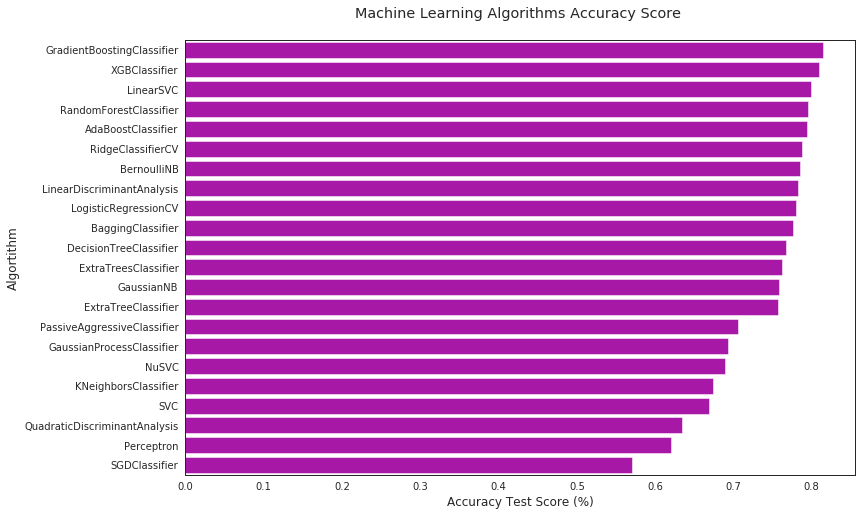

In [22]:
sns.barplot(x = 'MLA_Test_Accuracy_Mean', y = 'MLA_names', data = MLA_compare, color = 'm')

plt.title('Machine Learning Algorithms Accuracy Score \n')
plt.ylabel('Algortithm')
plt.xlabel('Accuracy Test Score (%)')

## Gradient Boosting Classifier

Since GradientBoostingClassifier turns out to be the most effective we use it to make predictions. <br>Fine tuning the hyperparameters can be done now.

Resplit the data just to make sure there aren't any discrepancies. Plus if you don't perform the comparison, you can directly run from here.

In [23]:
np.random.seed(0)
from sklearn import model_selection
X_train, X_val, y_train, y_val = model_selection.train_test_split(df_train,target, test_size = 0.2, train_size = 0.8, random_state = 0 )
#print(X_train.shape,y_train.shape,X_val.shape, y_val.shape)

Import the ensemble module from sklearn library. Set up the model along with parameters and hyperparameters.

In [24]:
from sklearn import ensemble
alg = ensemble.GradientBoostingClassifier(n_estimators= 100, random_state = 0)

## Training

We use the simpler `cross_val_score` now since we just need accuracy now. <br>
After we fit out data on the training set we check to validate how well it generalizes.

In [25]:
train_score = np.mean(model_selection.cross_val_score(alg, X_train, y_train, cv=5))

alg.fit(X_train, y_train)
survived = alg.predict(X_val)

print(train_score)
#print(test_score)
#print(survived.shape,y_val.shape,X_val.shape)
equals = survived == y_val.values.reshape(*survived.shape)
print(f"Accuracy = {np.mean(equals.astype(int))*100:.3f}%")

0.8216357112071826
Accuracy = 82.682%


## Predictions

In [26]:
survived_test = alg.predict(df_test)
submission = pd.DataFrame({'PassengerId':df_test.index,'Survived':survived_test})
#submission.to_csv('./submission.csv',index=False)
!ls

__notebook__.ipynb  __output__.json  submission.csv
